In [2]:
import pandas as pd
import numpy as np
import requests

In [32]:
def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-12-01').timestamp()))
        }
    )
    if 'error' in res.json().keys():
        res = requests.get(
        f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-12-01').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH','SOL','AVAX','USDT','FLOW']

In [33]:
df_base = pd.concat(get_data(token) for token in tokens)

In [35]:
#show the total df
df_base.head()

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-12-01 00:00:00,4656.62,4672.43,4624.16,4634.95,6013.006735,2.793321e+07,ETH
1,2021-12-01 01:00:00,4636.43,4736.90,4605.49,4729.10,13819.061610,6.487693e+07,ETH
2,2021-12-01 02:00:00,4729.10,4729.10,4684.49,4695.78,7491.465440,3.524161e+07,ETH
3,2021-12-01 03:00:00,4695.78,4754.97,4672.30,4754.09,10530.834423,4.963273e+07,ETH
4,2021-12-01 04:00:00,4754.09,4774.74,4722.02,4764.59,12471.624735,5.924627e+07,ETH


In [39]:
#Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume
df_base.groupby('token')['volumeUSD'].sum().sort_values(ascending = False)

token
ETH     1.418135e+10
SOL     4.485754e+09
AVAX    1.809343e+09
USDT    1.091270e+09
FLOW    4.878989e+07
Name: volumeUSD, dtype: float64

In [41]:
df_token = {}
for token in tokens:
    df_token[token] = get_data(token)
df_eth_sol = pd.merge(df_token['ETH'],df_token['SOL'],on='ts')

In [55]:
df_eth_sol = df_eth_sol.set_index('ts')
df_eth_sol = df_eth_sol[['close_x','close_y']]
df_eth_sol.columns = ['close_eth','close_sol']

In [57]:
df_eth_sol['close_ratio'] = df_eth_sol.close_eth/df_eth_sol.close_sol

In [59]:
#Add a column that calculates the close price ratio 
#between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)
df_eth_sol.head()

,close_eth,close_sol,close_ratio
ts,,,
2021-12-01 00:00:00,4634.95,208.676,22.211227
2021-12-01 01:00:00,4729.10,211.507,22.359071
2021-12-01 02:00:00,4695.78,210.868,22.268813
2021-12-01 03:00:00,4754.09,214.150,22.199813
2021-12-01 04:00:00,4764.59,215.176,22.142758


In [64]:
#Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm
df_base = df_base.rename(columns ={
    'volume':'volumeBase',
    'volumeUSD':'volumeTerm'
})

In [66]:
df_base_close = df_base[['ts','close','token']]

In [85]:
#create a fat table indexed by the timestamp, and each column is the close price of each token 
#(i.e. this should be a table of 200 rows and 5 columns)
df_base_close = df_base_close.set_index(['ts','token']).unstack()['close']

In [90]:
def logreturn(df):
    df['logreturn'] = np.log(df['close']/df['close'].shift(1))
    return df
df_base_return = df_base.groupby('token').apply(lambda x: logreturn(x))

In [92]:
#calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))
df_base_return.head()

,ts,open,high,low,close,volumeBase,volumeTerm,token,logreturn
0,2021-12-01 00:00:00,120.52,122.69,120.40,121.22,58982.875,7.178868e+06,AVAX,NaN
1,2021-12-01 01:00:00,121.28,124.40,120.49,124.06,66106.301,8.146064e+06,AVAX,0.023158
2,2021-12-01 02:00:00,124.07,127.18,123.88,127.09,80354.716,1.008255e+07,AVAX,0.024130
3,2021-12-01 03:00:00,127.07,127.59,122.84,124.59,82091.857,1.023314e+07,AVAX,-0.019867
4,2021-12-01 04:00:00,124.48,126.65,123.34,125.72,91628.118,1.146038e+07,AVAX,0.009029


In [99]:
#calculate the correlation of the tokens using the table above
df_base_close.corr()

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.877038,0.969869,0.880892,0.109355
ETH,0.877038,1.000000,0.889858,0.864858,0.119904
FLOW,0.969869,0.889858,1.000000,0.921420,0.083820
SOL,0.880892,0.864858,0.921420,1.000000,0.313074
USDT,0.109355,0.119904,0.083820,0.313074,1.000000


In [100]:
import seaborn as sns

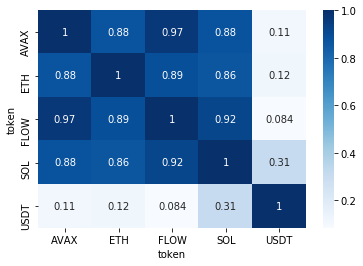

In [101]:
#visualize the correlation in a matplpotlib plot
sns.heatmap(df_base_close.corr(), cmap='Blues', annot=True)